# Libraries and GPU preparation

In [1]:
import os
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import numpy as np
import pandas as pd
import librosa
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import wandb
from sklearn.metrics import confusion_matrix
import sklearn
import itertools
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional
import tensorflow_io as tfio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [3]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Dataset preparation

In [4]:
timit_map_str = """
h# 0
d 1
ih 2
dcl 3
jh 4
ux 5
n 6
ow 7
hv 8
iy 9
z 10
ae 11
v 12
axr 13
tcl 14
t 15
ay 16
ng 17
hh 18
m 19
r 20
ey 21
ax 22
kcl 23
k 24
w 25
q 26
ix 27
f 28
s 29
l 30
dh 31
epi 32
eh 33
b 34
ao 35
th 36
er 37
bcl 38
aw 39
y 40
aa 41
ax-h 42
ah 43
nx 44
en 45
ch 46
sh 47
pcl 48
p 49
dx 50
el 51
oy 52
gcl 53
g 54
pau 55
uw 56
zh 57
uh 58
em 59
eng 60
"""
timit_char_map = {}
timit_index_map = {}
for line in timit_map_str.strip().split('\n'):
	ch, index = line.split()
	timit_char_map[ch] = int(index)
	timit_index_map[int(index)] = ch

In [5]:
TRAIN='./timit_LDC93S1/timit/TIMIT/TRAIN/'
train_phn = []
train_mfcc = []
train_timesteps=[]
for dr1 in os.listdir(TRAIN):
    dr1_path=TRAIN+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"):# and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                        
                if (len(mfcc_feat) - len(labels)) == 1:
                    labels.append('h#')
                    
                if len(mfcc_feat) == len(labels):
                    train_mfcc.append(np.array(mfcc_feat))
                    train_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    train_timesteps.append(np.array(timesteps))
                    
                    # masked
                    mfcc_masked = tfio.experimental.audio.freq_mask(mfcc_feat, param=10)
                    for _ in range(0,int(mfcc_feat.shape[0]/50)):
                        mfcc_masked = tfio.experimental.audio.time_mask(mfcc_masked, param=5)
                        
                    train_mfcc.append(np.array(mfcc_masked))
                    train_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    train_timesteps.append(np.array(timesteps))
                    

In [6]:
TEST='./timit_LDC93S1/timit/TIMIT/TEST/'
test_phn = []
test_mfcc = []
test_timesteps=[]
for dr1 in os.listdir(TEST):
    dr1_path=TEST+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"): #and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                
                if (len(mfcc_feat) - len(labels)) == 1:
                    labels.append('h#')
                    
                if len(mfcc_feat) == len(labels):
                    test_mfcc.append(np.array(mfcc_feat))
                    test_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    test_timesteps.append(np.array(timesteps))

# Model Training

In [90]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(512, return_sequences=True,dropout=0.1)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
tf.keras.backend.clear_session()

In [ ]:
with tf.device('/device:GPU:0'):
    def train_generator():
        while True:
            i = np.random.randint(0, len(train_phn))
            yield train_mfcc[i][np.newaxis,:,:], train_phn[i][np.newaxis,:]

    model.fit(train_generator(), steps_per_epoch=1000, epochs=30, verbose=1)
    model.summary()

In [8]:
def test_generator():
    while True:
        i = np.random.randint(0, len(test_mfcc))
        yield test_mfcc[i][np.newaxis,:,:], test_phn[i][np.newaxis,:]

In [76]:
model.save("../api/static/BI_LSTM_512_30epochs_dropout01.h5")

# Phone Classification Results

In [5]:
model = tf.keras.models.load_model('../api/static/BI_LSTM_512_30epochs_dropout01.h5')

In [10]:
model.evaluate(test_generator(),steps=len(test_mfcc))

1628/1628 [==============================] - 24s 13ms/step - loss: 1.0353 - accuracy: 0.6853


[1.0353443622589111, 0.6852866411209106]

In [11]:
pred_labels = []
true_labels = []

for i in range(0,len(test_mfcc)):
    pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
    pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
    true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

In [12]:
flat_pred = [item for sublist in pred_labels for item in sublist]
flat_true = [item for sublist in true_labels for item in sublist]

In [13]:
accuracy_score(flat_true, flat_pred)

0.6869411628214002

In [14]:
cnf = sklearn.metrics.confusion_matrix(flat_true, flat_pred)

In [15]:
def plot_big_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(40,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title,fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=20)
    plt.yticks(tick_marks, classes,fontsize=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()
    plt.savefig('confusion_matrix_phn.png')

Normalized confusion matrix
[[6.42210473e-01 1.57890925e-02 3.18678931e-02 ... 1.15883248e-03
  2.89708119e-04 0.00000000e+00]
 [6.19947428e-03 7.45325596e-01 8.33209344e-03 ... 1.98383177e-04
  4.46362148e-04 4.95957943e-05]
 [1.06410589e-01 3.47780950e-02 3.75811056e-01 ... 5.19076045e-04
  2.98468726e-03 0.00000000e+00]
 ...
 [4.67726848e-04 2.33863424e-04 9.35453695e-04 ... 6.17633302e-01
  9.35453695e-04 2.33863424e-04]
 [9.55840184e-05 1.91168037e-04 1.91168037e-04 ... 1.91168037e-04
  6.68323456e-01 1.81609635e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.19594595e-02
  2.33108108e-01 2.11148649e-01]]


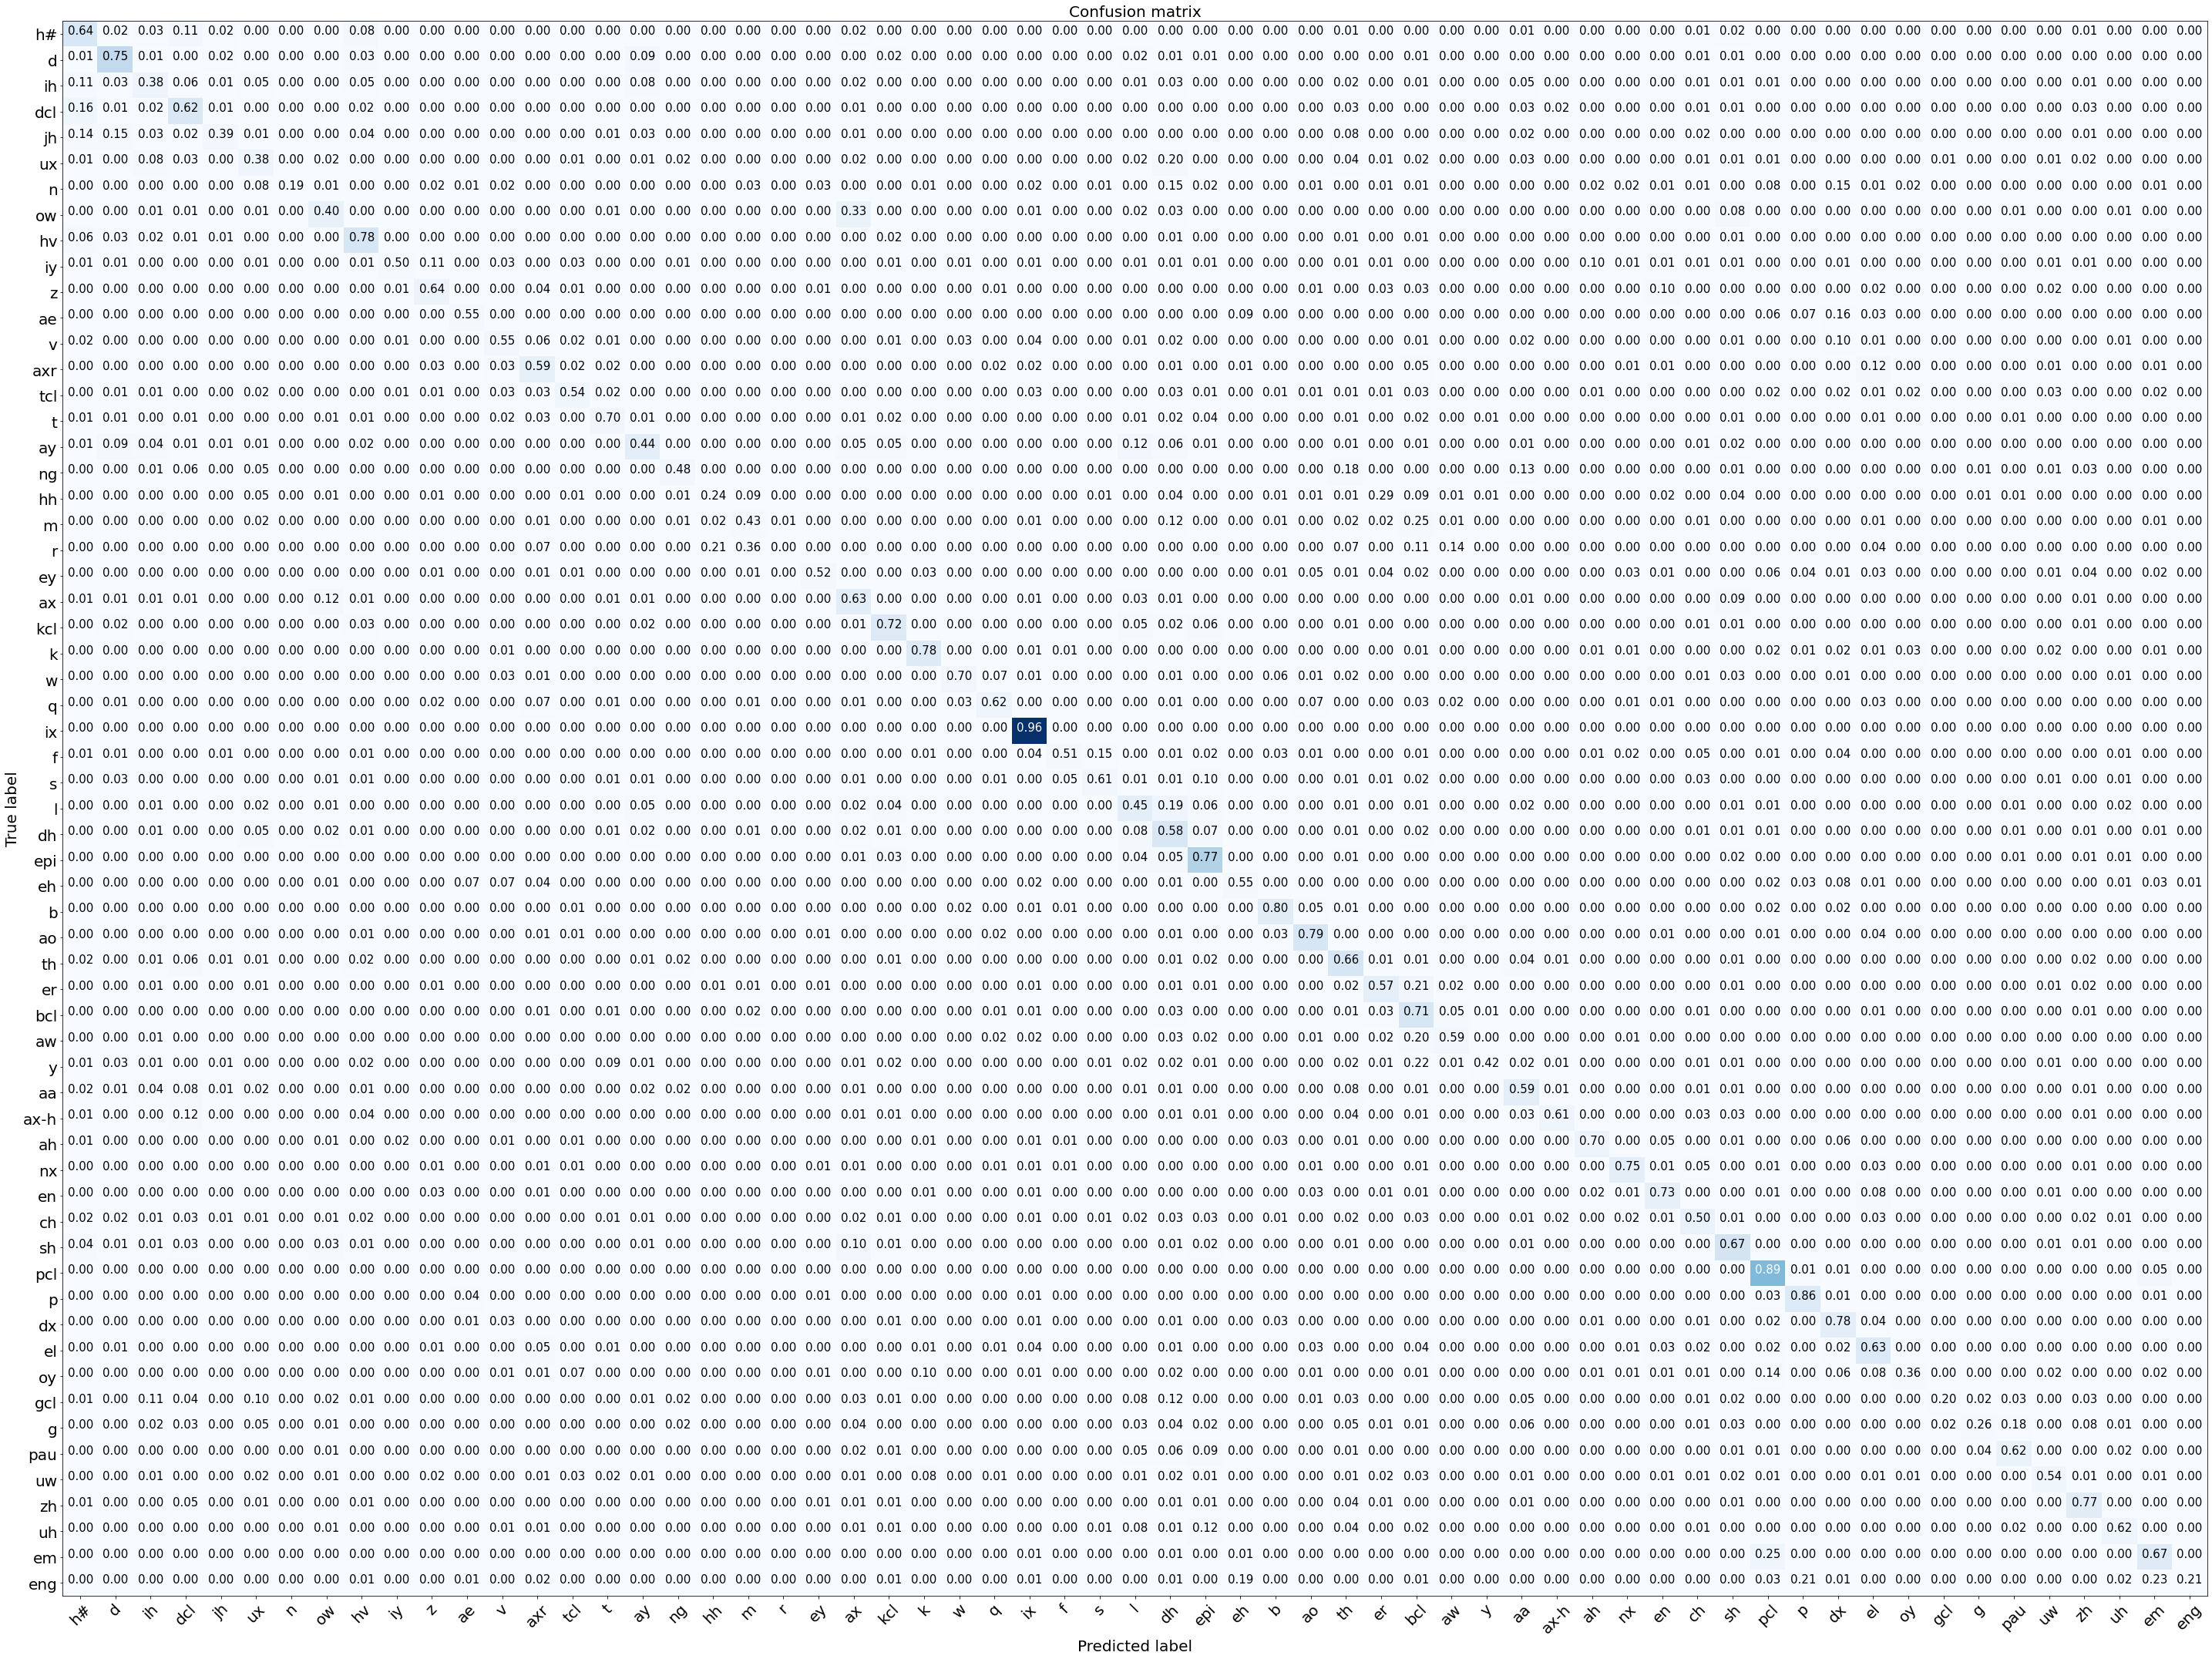

In [16]:
plot_big_confusion_matrix(cnf,timit_char_map.keys(),normalize=True)

# Visime Classification Results

In [18]:
visime_map_str = """
h# 0
d 5
ih 2
dcl 0 
jh 7
ux 2
n 6
ow 9 
hv 7
iy 2
z 5
ae 8 
v 3
axr 2
tcl 0 
t 5
ay 10 
ng 6
hh 6
m 1 
r 7
ey 8 
ax 2
kcl 0 
k 6
w 4
q 0 
ix 2
f 3
s 7
l 6
dh 5
epi 0 
eh 8 
b 1 
ao 9 
th 5
er 7
bcl 0 
aw 9 
y 2
aa 9
ax-h 2
ah 10
nx 6
en 6
ch 7
sh 7
pcl 0 
p 1
dx 6
el 6
oy 9
gcl 0 
g 6
pau 0 
uw 4
zh 7
uh 4
em 1
eng 6
"""
visime_char_map = {}
visime_index_map = {}
for line in visime_map_str.strip().split('\n'):
	ch, index = line.split()
	visime_char_map[ch] = int(index)
	visime_index_map[int(index)] = ch

In [19]:
flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
flat_vis_true = [visime_char_map[ph] for ph in flat_true]

In [20]:
labels = sorted(list(visime_index_map.keys()))

In [21]:
cnf_vis = sklearn.metrics.confusion_matrix(flat_vis_true, flat_vis_pred)

In [22]:
cnf_vis

array([[111624,    864,   2084,    707,    400,   2148,   3887,   1922,
           561,    766,    361],
       [   986,   9262,    506,    170,    215,    475,   2708,    234,
           129,    129,    133],
       [  1237,    280,  60253,    224,    940,    837,   2903,   7169,
          2717,   1161,   1087],
       [   652,    196,    434,   9848,     68,    872,    441,    494,
            76,     97,     58],
       [   180,    100,   1425,     32,   7597,     45,    743,    392,
           105,    981,    314],
       [  1754,    193,    841,    472,     28,  18382,    849,   3670,
           172,    140,     68],
       [  2401,    802,   2379,    201,    633,    771,  38579,   1181,
           683,   2915,    579],
       [  1223,    141,   3375,    227,    238,   2900,    864,  58313,
           790,   1545,    559],
       [   670,     81,   4645,     53,    136,    184,    689,   1559,
         32168,   1093,   1668],
       [   683,     97,    834,    101,    753,    114,

In [36]:
def plot_small_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(40,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title,fontsize=60)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=60)
    plt.yticks(tick_marks, classes,fontsize=60)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 fontsize=50,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label',fontsize=60)
    plt.xlabel('Predicted label',fontsize=60)
    plt.tight_layout()
    plt.savefig('confusion_matrix_vis.png')

Normalized confusion matrix
[[0.89068335 0.00689413 0.0166289  0.00564138 0.00319173 0.01713957
  0.03101561 0.01533625 0.0044764  0.00611216 0.00288053]
 [0.06596641 0.61965612 0.03385295 0.01137352 0.01438416 0.03177895
  0.18117348 0.01565532 0.00863049 0.00863049 0.00889811]
 [0.01569638 0.00355294 0.76455436 0.00284235 0.01192772 0.01062075
  0.03683636 0.09096792 0.0344762  0.01473201 0.01379302]
 [0.0492596  0.0148081  0.03278936 0.74403143 0.0051375  0.06588093
  0.03331822 0.03732245 0.00574192 0.0073285  0.00438199]
 [0.01510828 0.00839349 0.11960718 0.00268592 0.63765318 0.00377707
  0.06236361 0.03290247 0.00881316 0.0823401  0.02635555]
 [0.06601679 0.0072641  0.03165343 0.01776506 0.00105386 0.69185893
  0.03195453 0.1381309  0.00647371 0.0052693  0.00255937]
 [0.04696424 0.01568735 0.04653392 0.00393162 0.01238166 0.01508098
  0.75461623 0.0231007  0.01335967 0.05701823 0.0113254 ]
 [0.01742786 0.00200926 0.04809405 0.00323477 0.00339152 0.04132526
  0.01231208 0.8309654

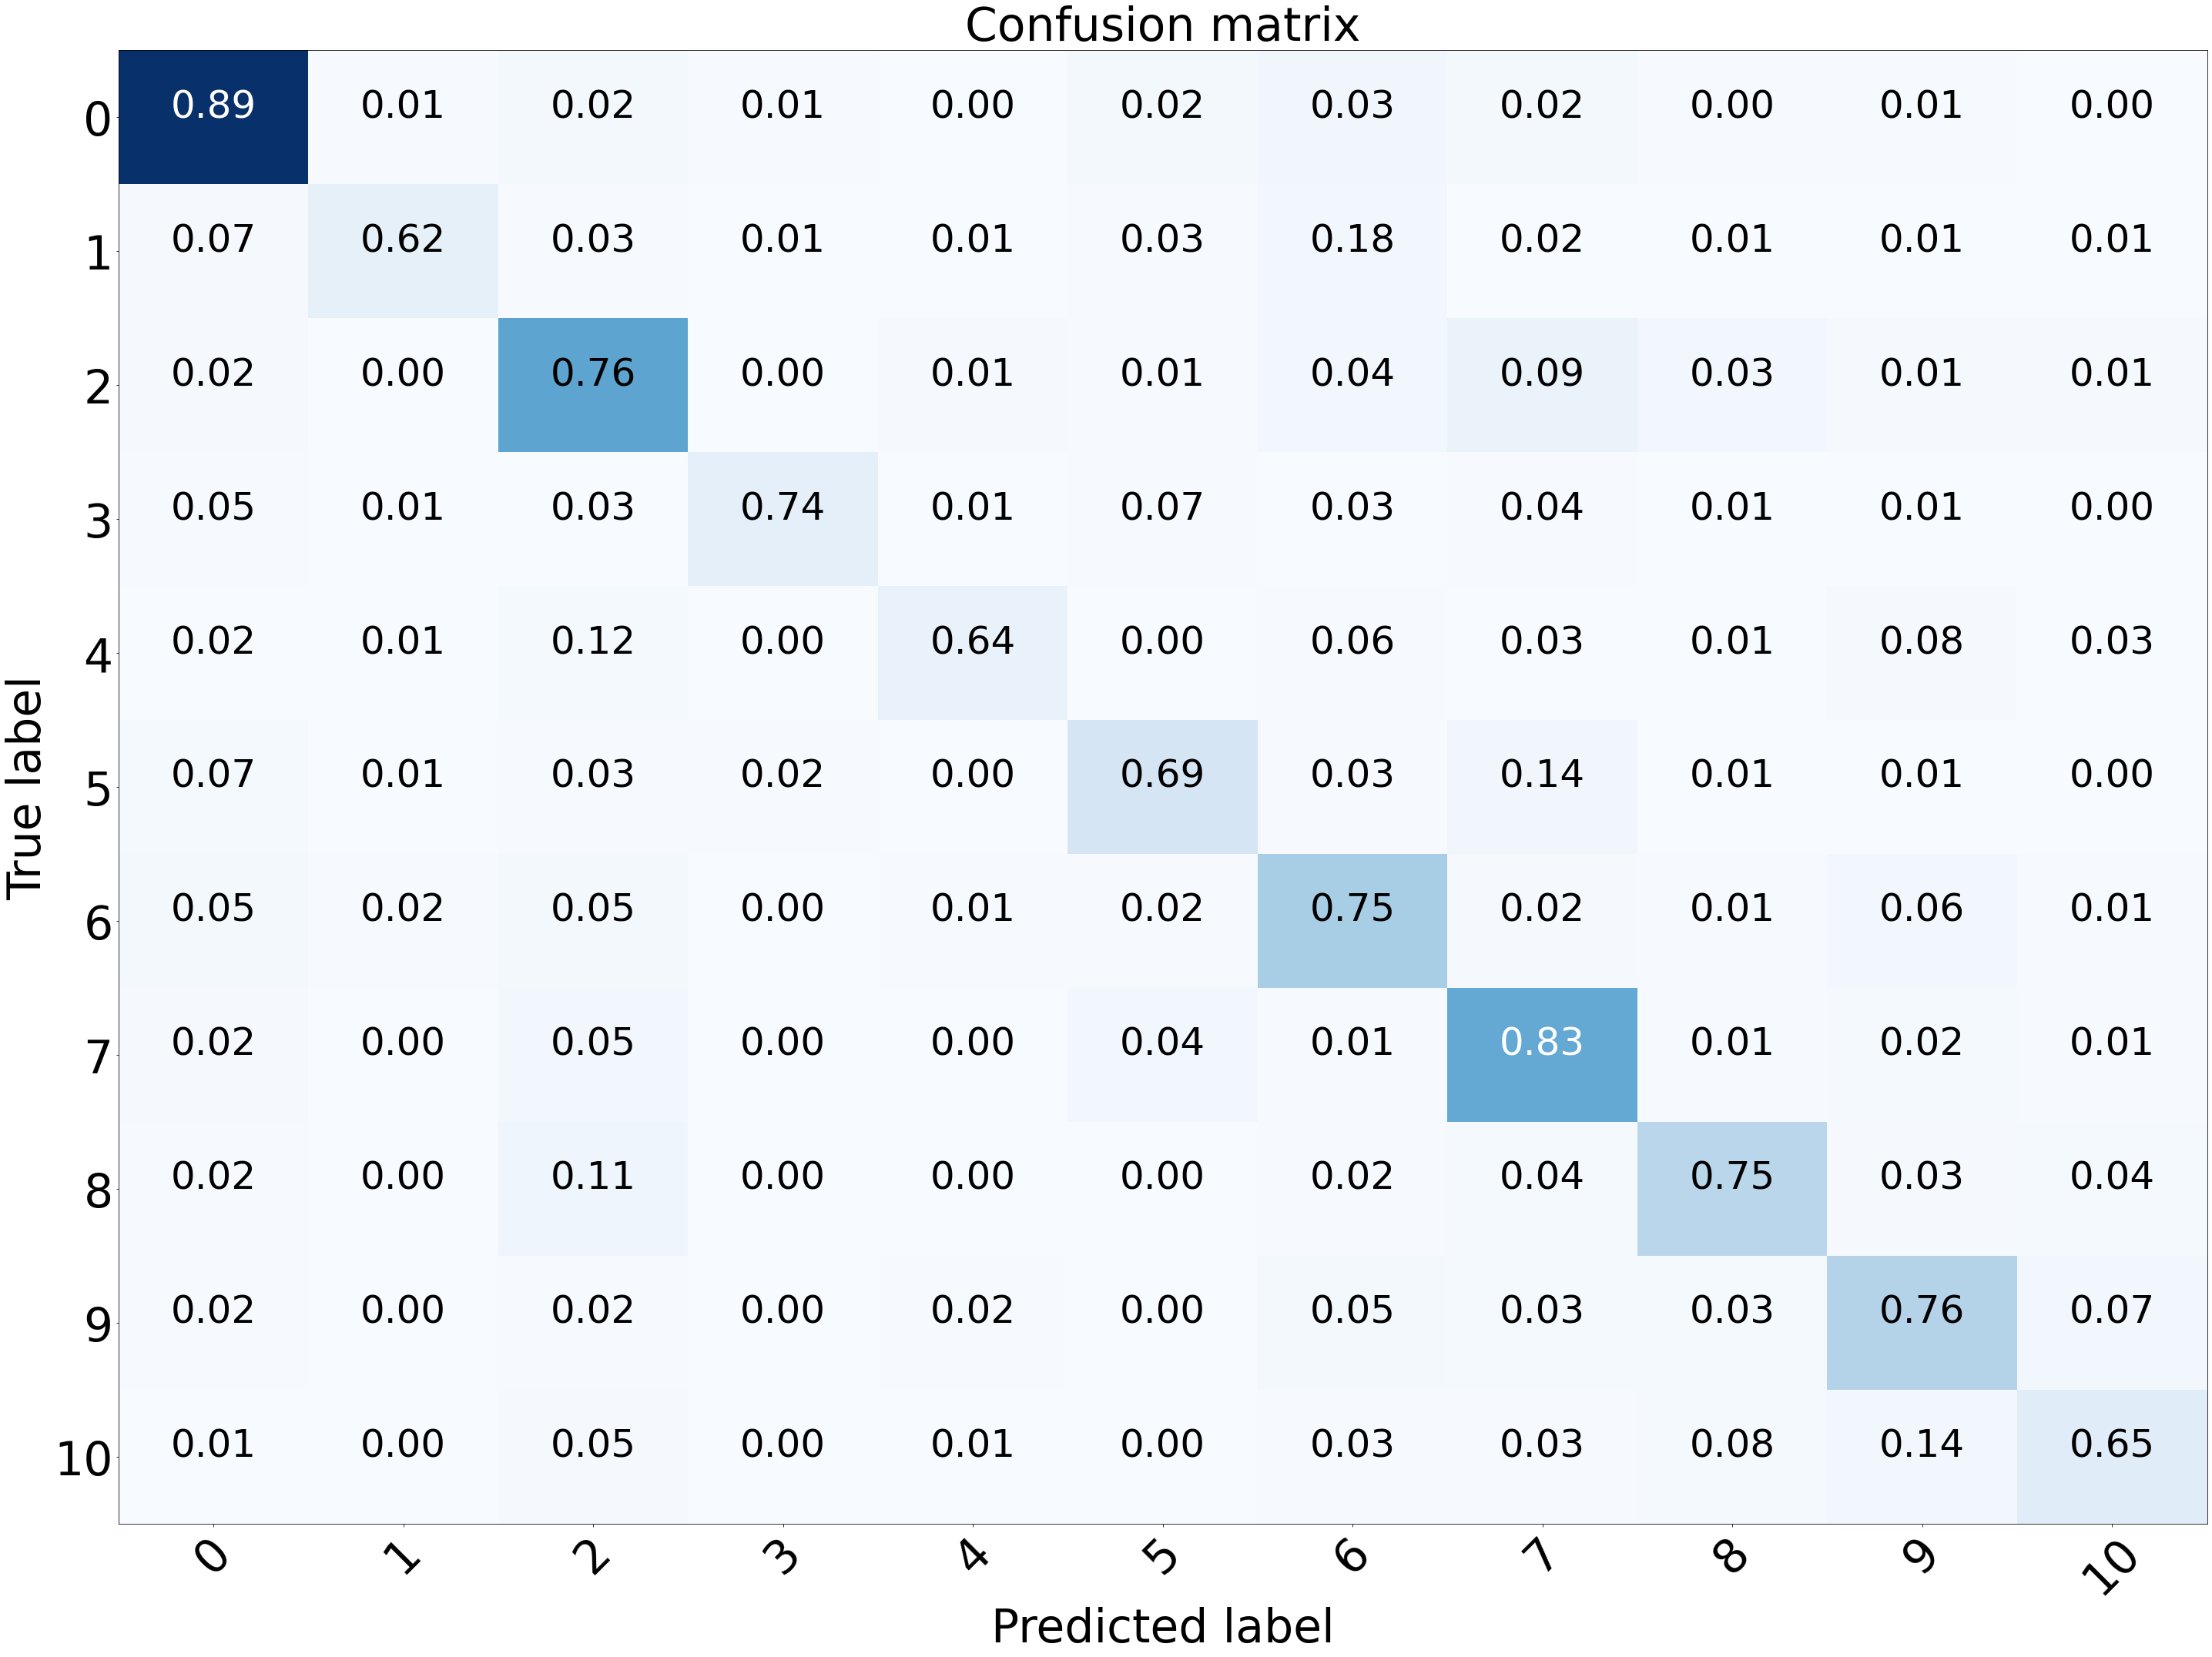

In [37]:
plot_small_confusion_matrix(cnf_vis,labels,normalize=True)

In [26]:
accuracy_score(flat_vis_true, flat_vis_pred)

0.786530698789011

In [28]:
print(sklearn.metrics.classification_report(flat_vis_true, flat_vis_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90    125324
           1       0.77      0.62      0.69     14947
           2       0.77      0.76      0.77     78808
           3       0.82      0.74      0.78     13236
           4       0.68      0.64      0.66     11914
           5       0.69      0.69      0.69     26569
           6       0.71      0.75      0.73     51124
           7       0.76      0.83      0.79     70175
           8       0.80      0.75      0.77     42946
           9       0.75      0.76      0.75     45072
          10       0.62      0.65      0.64     19807

    accuracy                           0.79    499922
   macro avg       0.75      0.74      0.74    499922
weighted avg       0.79      0.79      0.79    499922

